<a href="https://colab.research.google.com/github/israelkingz/air_pollution/blob/master/air_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import lightgbm as lgb
import gc
from fastai.tabular import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
from tqdm import tqdm_notebook

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [ ]:
train = pd.read_csv('/Train.csv')
test = pd.read_csv('/Test.csv')
sample_sub = pd.read_csv('/SampleSubmission.csv')

### Converting to datetime to use date features.

In [ ]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')

In [ ]:
ID_COL, TARGET_COL = 'Place_ID X Date', 'target'
df = pd.concat([train, test]).reset_index(drop=True)
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID', 'target_max', 'target']]


In [ ]:
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,...,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92.0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,...,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91.0,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,...,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.000050,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96.0,16.400000,33.400002,0.00750,27.031030,5.065727,3.500559,0.000067,0.000170,-1.001242,0.015904,841410.713456,-

## Feature Engineering

### Frequency Encoding

We cannot use the PlaceID directly since its different for both train and test data, but we can use the the number of times each place appears in the dataframe is not same for every place.

In [ ]:
df['placeID_freq'] = df['Place_ID'].map(df['Place_ID'].value_counts())

In [ ]:
df.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

### Time Series Features

### A. Using Previous and Future Target Values.

Pollution levels yesterday could tell about the pollution levels today, similary pollution levels tomorrow, could also tell about pollution levels today. We add this information to our dataset, using shift and expanding functions

In [ ]:
for i in range(1, 20):
    df[f'prev_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].fillna(method='ffill').shift(i).sort_index()
    df[f'next_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].fillna(method='bfill').shift(-i).sort_index()

In [ ]:
for i in tqdm_notebook(range(1, 15)):
    df[f'magic_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).expanding().mean().fillna(method='ffill').sort_index()
    df[f'magic2_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).expanding().mean().fillna(method='bfill').sort_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### B. Cyclic Components

Date has cyclic components, for example monday repeats after every 7 days, adding this as a feature can help capture more information from the dataset.

To read more visit:

https://docs.fast.ai/tabular.transform.html#add_cyclic_datepart

In [ ]:
for i in tqdm_notebook(range(1, 45)):
    c = 'Date' + str(i+1)
    df[c] = df['Date']  + datetime.timedelta(days=i)
    _ = add_cyclic_datepart(df, c, prefix = c)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### C. Sensor Readings of previous and future days.

Similar to the pollution readings of previous and future days, we can utilize the sensor readings of previous and future days too, to help predict the pollution for today, also the difference between the sensor readings today and sensor readings from the past and future can help. I added 10 days worth of this information to the dataset, you are free to experiment with more or lesser number of days

In [ ]:

    
for i in tqdm_notebook(range(1, 11)):
    tmp = df.sort_values(by='Date').groupby('Place_ID')[features].shift(i).sort_index()
    tmp_diff_prev = df[features] - tmp
    tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
    tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
    df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
    
    tmp = df.sort_values(by='Date').groupby('Place_ID')[features].shift(-i).sort_index()
    tmp_diff_next = df[features] - tmp
    tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
    tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
    df = pd.concat([df, tmp, tmp_diff_next], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


### D. Using simple features extracted from the date itself.
Like dayofweek, weekend or not, month, days_in_month, etc.

In [ ]:
for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    df[attr] = getattr(df['Date'].dt, attr)
df['is_weekend'] = (df['dayofweek'] >= 5)*1
df['fortnight'] = df['day']%15
df['which_fortnight'] = df['day']//15

add_cyclic_datepart(df, "Date", prefix = "Current_Date_")

,Place_ID X Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,...,L3_AER_AI_sensor_azimuth_angle_next_diff_10,L3_AER_AI_sensor_zenith_angle_next_diff_10,L3_AER_AI_solar_azimuth_angle_next_diff_10,L3_AER_AI_solar_zenith_angle_next_diff_10,L3_SO2_SO2_column_number_density_next_diff_10,L3_SO2_SO2_column_number_density_amf_next_diff_10,L3_SO2_SO2_slant_column_number_density_next_diff_10,L3_SO2_absorbing_aerosol_index_next_diff_10,L3_SO2_cloud_fraction_next_diff_10,L3_SO2_sensor_azimuth_angle_next_diff_10,L3_SO2_sensor_zenith_angle_next_diff_10,L3_SO2_solar_azimuth_angle_next_diff_10,L3_SO2_solar_zenith_angle_next_diff_10,L3_CH4_CH4_column_volume_mixing_ratio_dry_air_next_diff_10,L3_CH4_aerosol_height_next_diff_10,L3_CH4_aerosol_optical_depth_next_diff_10,L3_CH4_sensor_azimuth_angle_next_diff_10,L3_CH4_sensor_zenith_angle_next_diff_10,L3_CH4_solar_azimuth_angle_next_diff_10,L3_CH4_solar_zenith_angle_next_diff_10,day,month,week,dayofweek,weekofyear,days_in_month,is_month_start,is_month_end,dayofyear,is_weekend,fortnight,which_fortnight,Current_Date_weekday_cos,Current_Date_weekday_sin,Current_Date_day_month_cos,Current_Date_day_month_sin,Current_Date_month_year_cos,Current_Date_month_year_sin,Current_Date_day_year_cos,Current_Date_day_year_sin
0,010Q650 X 2020-01-02,010Q650,38.0,23.0,53.0,769.50,92.0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,...,0.252942,17.194809,0.517031,-2.279040,0.000058,-0.035038,0.000023,-1.420210,-0.004702,0.251855,17.153542,0.501163,-2.273543,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118,2,1,1,3,1,31,False,False,2,0,2,0,-0.900969,0.433884,0.979530,0.201299,1.000000e+00,0.000000,0.999853,0.017166
1,010Q650 X 2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91.0,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,33.089495,...,-91.454571,14.178452,-13.334323,7.181467,0.000472,0.111469,0.000154,-1.873905,0.059433,-91.455261,14.163171,-13.343391,7.183079,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652,3,1,1,4,1,31,False,False,3,0,3,0,-0.900969,-0.433884,0.918958,0.394356,1.000000e+00,0.000000,0.999411,0.034328
2,010Q650 X 2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96.0,16.400000,33.400002,0.00750,27.031030,5.065727,3.500559,0.000067,0.000170,-1.001242,0.015904,841410.713456,-105.201338,49.839714,-78.342701,34.296977,0.000059,7311.869141,0.000007,0.115876,232.233484,0.082063,-105.201338,49.839714,-78.342701,34.296977,0.020677,1109

In [ ]:
df.isnull().sum()

Place_ID X Date                    0
Place_ID                           0
target                         16136
target_min                     16136
target_max                     16136
                               ...  
Current_Date_day_month_sin         0
Current_Date_month_year_cos        0
Current_Date_month_year_sin        0
Current_Date_day_year_cos          0
Current_Date_day_year_sin          0
Length: 3480, dtype: int64

## Modelling.

1. The best idea would be do a grouped KFold validation strategy, since train and test set had different sets of places, but I realised it later, so decided to stick with Stratified KFold.
2. Using stratification for regression can be done if you divided the target into bins, here I divided the target into 10 different quantiles.
3. 10 fold validation was performed with averaging of each prediction.

In [ ]:
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID',
                                               'target_max', 'target',  'month_year_cos','month_year_sin','day_year_cos','day_year_sin']]
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)
target = train[TARGET_COL]
len(features)

3473

In [ ]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 50, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.075,
         "boosting": "gbdt",
         "feature_fraction": 0.35,
         "metric": 'auc',
         "lambda_l1": 1,
         "lambda_l2": 2,
         "random_state": 6,
         "verbosity": -1,
          'metric' : 'rmse',
          'num_iterations': 500}

In [ ]:
target_cols = ['target']
oofs_df = pd.DataFrame()
preds_df = pd.DataFrame()
for t_col in target_cols:
    oofs_df[t_col] = np.zeros(len(train))
    preds_df[t_col] = np.zeros(len(test))

In [ ]:
max_iter = 3
folds = StratifiedKFold(n_splits=max_iter, random_state=1901)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, pd.qcut(target, 3, labels=False, duplicates='drop'))):
    print("\nfold n°{}".format(fold_))
    X_trn, X_val, X_test = train.iloc[trn_idx][features], train.iloc[val_idx][features], test[features]
    for t_col in target_cols:
        target = train[t_col]
        print(f"\n\n**** {t_col} ****\n")
        y_trn, y_val = target.iloc[trn_idx], target.iloc[val_idx]
        trn_data = lgb.Dataset(X_trn, y_trn)
        val_data = lgb.Dataset(X_val, y_val)
        
        clf = lgb.train(param, trn_data, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 200)

        oofs_df[t_col][val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
        current_test_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
        current_test_pred[current_test_pred < 0] = 0
        preds_df[t_col] += current_test_pred / folds.n_splits

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



fold n°0


**** target ****



/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 19.1972	valid_1's rmse: 32.6607
[100]	training's rmse: 13.4922	valid_1's rmse: 31.6368
[150]	training's rmse: 10.2987	valid_1's rmse: 31.3458
[200]	training's rmse: 8.21505	valid_1's rmse: 31.1871
[250]	training's rmse: 6.72219	valid_1's rmse: 31.1002
[300]	training's rmse: 5.63141	valid_1's rmse: 31.0611
[350]	training's rmse: 4.7772	valid_1's rmse: 31.0257
[400]	training's rmse: 4.10072	valid_1's rmse: 31.0092
[450]	training's rmse: 3.56005	valid_1's rmse: 30.9925
[500]	training's rmse: 3.11464	valid_1's rmse: 30.984
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 3.11464	valid_1's rmse: 30.984

fold n°1


**** target ****

Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 20.0609	valid_1's rmse: 30.1992
[100]	training's rmse: 14.5754	valid_1's rmse: 28.8168
[150]	training's rmse: 11.4175	valid_1's rmse: 28.3769
[200]	training's rmse: 9.28755	

## Feature Importances

On assessing feature importances we find out that,previous and next values, are indeed important. Also placeID_freq is in the top 10 features. Clever feature selection after analyzing feature importances can further help increase the score.

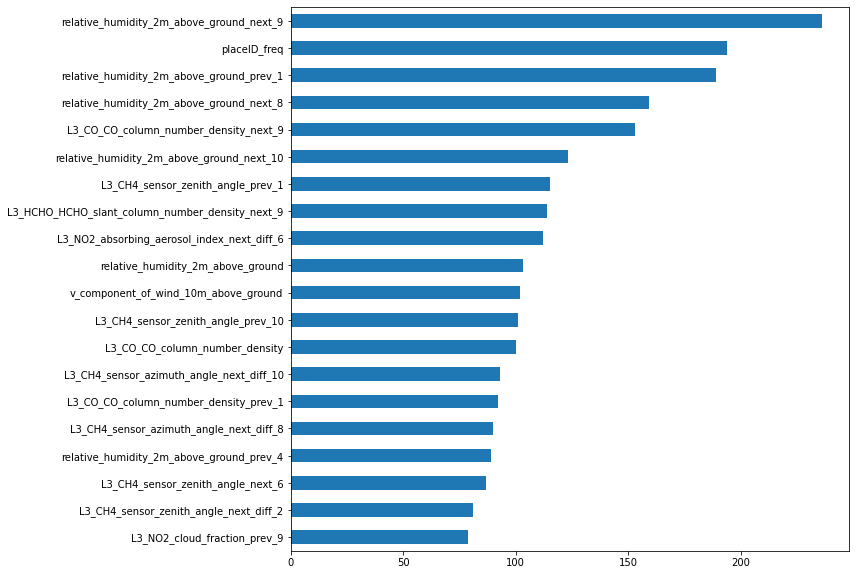

In [ ]:
_ = plt.figure(figsize=(10, 10))
fi = pd.Series(index=features, data=clf.feature_importance())
_ = fi.sort_values()[-20:].plot(kind='barh')

In [ ]:
rmse(target.values, oofs_df['target'].values)

28.70944609773069